# Getting Started

`osier` is the first multi- and many-objective energy system optimization platform. This notebook offers a quick start guide to using its functionality.

In [3]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
from unyt import MW, GW, km

# osier imports
from osier import CapacityExpansion
from osier.tech_library import nuclear_adv, wind, battery, natural_gas
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

Unit symbol 'megatonnes' already exists in the provided registry


TypeError: Units from unyt's default registry cannot be removed.

## Preparing input data

Users only need to supply relevant timeseries data to `osier`.

In [2]:
demand = np.ones(24)*100
wind_speed = np.random.weibull(a=2.5,size=24)

## Set up the problem

`osier` comes pre-loaded with technology data from the `osier.tech_library`. Users simply need to pass the data to a `CapacityExpansion` problem and run it using a `pymoo.minimize` runner.

In [8]:
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission],
                            solver='cbc')

In [11]:
%%time
res = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      5 |             - |             -
     2 |       40 |     11 |  0.0046772701 |         nadir
     3 |       60 |     14 |  0.1321541878 |         ideal
     4 |       80 |     19 |  0.0568080615 |         ideal
     5 |      100 |     20 |  0.0163522757 |         ideal
     6 |      120 |     20 |  0.0551161256 |         ideal
     7 |      140 |     19 |  0.0127490335 |             f
     8 |      160 |     20 |  0.0133780716 |             f
     9 |      180 |     20 |  0.0326894581 |         nadir
    10 |      200 |     20 |  0.0244893865 |         ideal
CPU times: user 4min 23s, sys: 10.4 s, total: 4min 33s
Wall time: 4min 49s


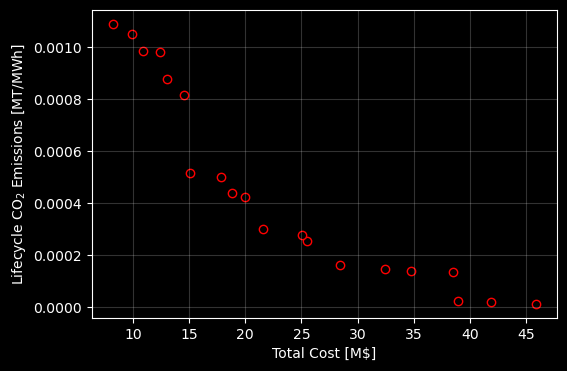

In [12]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_68821/1527621391.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res.X,


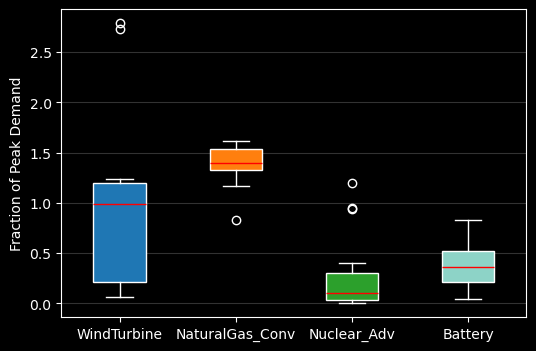

In [13]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()

## Create new objectives and modify technology data

`osier` allows users to modify the problem formulation on the fly. Both by adding new data fields or by creating a new objective.

Users can create new objectives for any quantifiable metric. Here we add a parameter called `land_use` to the modeled technologies.

In [14]:
nuclear_adv.land_use = 4.4*1e-3 * (km**2/GW)
natural_gas.land_use = 3.2*1e-3 * (km**2/GW)
wind.land_use = 12.3e3*1e-3 * (km**2/GW)
battery.land_use = 6.0*1e-3 * (km**2/GW)

Then, we create a function that calculates the total land use. The minimum required format is

```py
def objective(technology_list, solved_dispatch_model):
    # some calculation
    return objective
```

In [17]:
def land_use(technology_list, solved_dispatch_model):
    """
    Calculates land use intensity.
    """
    
    obj_value = np.array([t.capacity.to_value() * t.land_use for t in technology_list]).sum()
    
    return obj_value

Now, we re-initialize the problem with our new objective and updated technologies.

In [16]:
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission, land_use],
                            solver='cbc')

In [18]:
%%time
res = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      7 |             - |             -
     2 |       40 |     13 |  0.0526379833 |         ideal
     3 |       60 |     20 |  0.0375808870 |         ideal
     4 |       80 |     20 |  0.0347771750 |         ideal
     5 |      100 |     20 |  0.0179725139 |         ideal
     6 |      120 |     20 |  0.0211695257 |         ideal
     7 |      140 |     20 |  0.0491766028 |         ideal
     8 |      160 |     20 |  0.0485837849 |         ideal
     9 |      180 |     20 |  0.0392558668 |             f
    10 |      200 |     20 |  0.0330618627 |         ideal
CPU times: user 4min 10s, sys: 9.17 s, total: 4min 19s
Wall time: 4min 28s


## Visualization

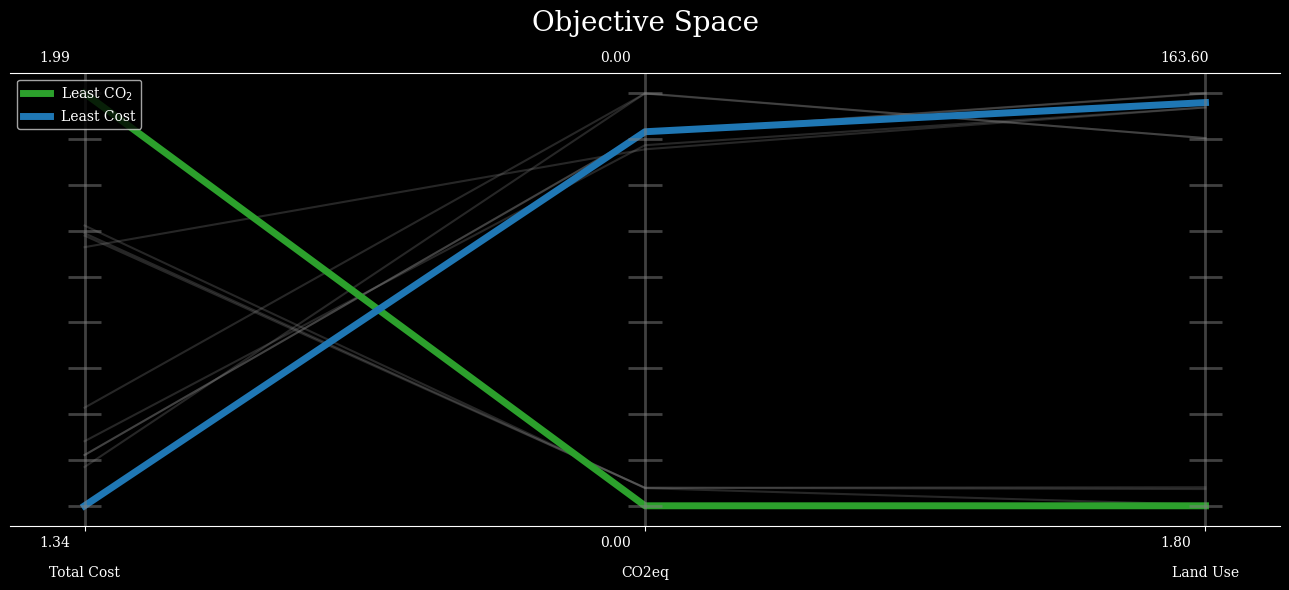

In [76]:
obj_labels=['Total Cost', 'CO2eq', 'Land Use']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_64638/3044223643.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res.X,


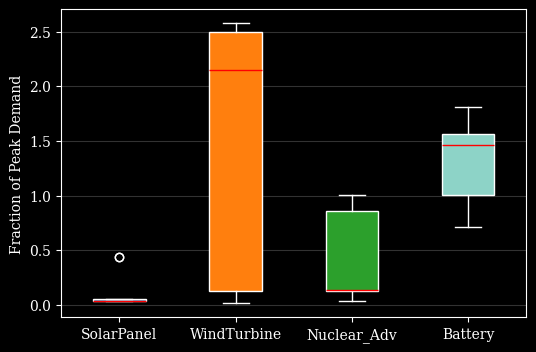

In [69]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()